In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pyquasar import Mesh, FemDomain, BemDomain, FetiProblem

%config InlineBackend.figure_format='retina'

In [2]:
plt.rcParams.update(
  {
    "figure.figsize": (6, 6),
    "axes.facecolor": "none",
    "font.size": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
  }
)

# FEM one domain test

/var/folders/ym/c485vn5d3gx7l4zk06n3_sg80000gn/T/ipykernel_11376/4027402298.py:15: DeprecationWarning: 'scipy.sparse.linalg.minres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14. Until then, if set, it will override `rtol`.
  sol = domain.solve_neumann(domain.load_vector)
/var/folders/ym/c485vn5d3gx7l4zk06n3_sg80000gn/T/ipykernel_11376/4027402298.py:22: DeprecationWarning: 'scipy.sparse.linalg.minres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14. Until then, if set, it will override `rtol`.
  f"Dirichlet problem error: {np.linalg.norm(domain.solve_dirichlet(dir_vector) - domain.load_vector)/np.linalg.norm(domain.load_vector)}"


Neumann problem error: 3.3977766912740966e-12
Dirichlet problem error: 9.657549206263254e-11


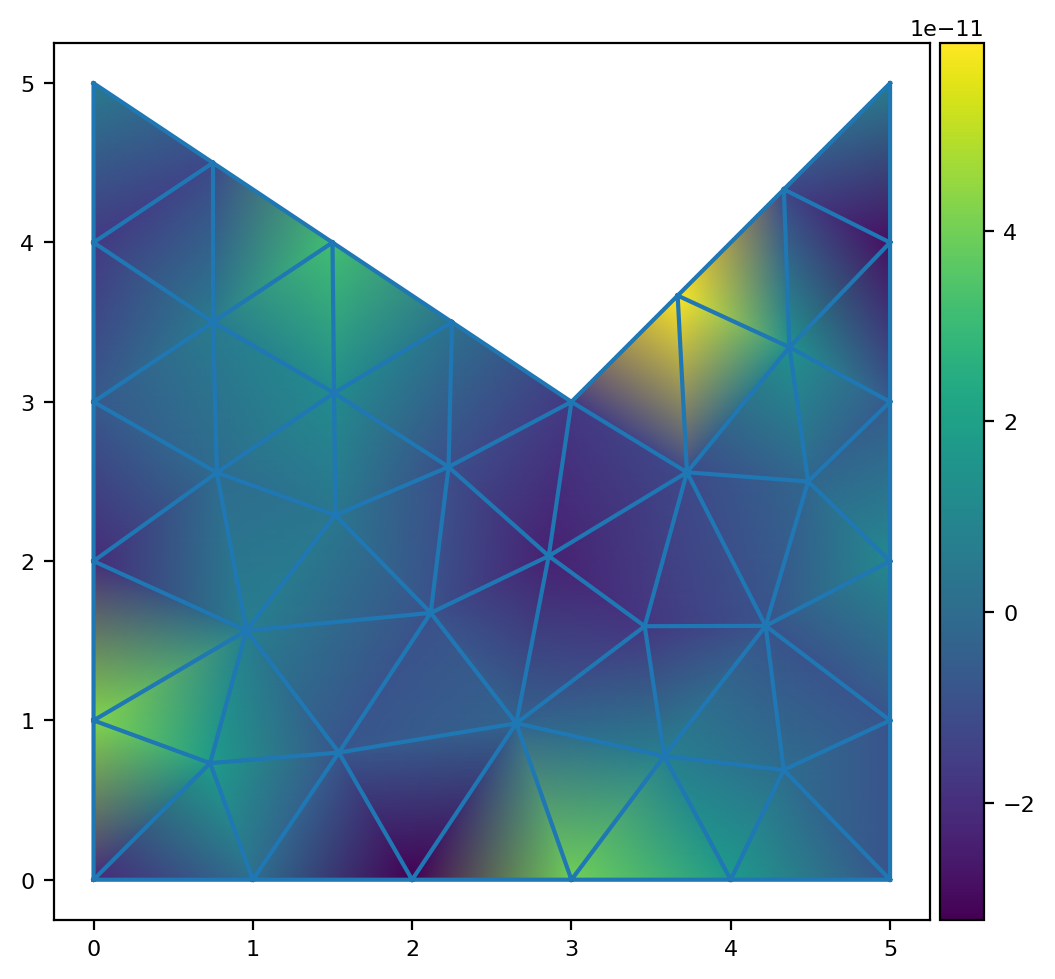

In [3]:
def u(p, n):
  # return p[..., 0] ** 2 - p[..., 1] ** 2
  return 2 * p[..., 0] + 3 * p[..., 1] - 4


def flow(p, n):
  # return 2 * p[..., 0] * n[..., 0] - 2 * p[..., 1] * n[..., 1]
  return 2 * n[..., 0] + 3 * n[..., 1]


domain = next(FemDomain(domain) for domain in Mesh.load("test.geo"))
dir_vector = u(domain.vertices[: domain.ext_dof_count], 0)

domain.assembly({"dirichlet": flow})
sol = domain.solve_neumann(domain.load_vector)

sol -= domain.kernel[0] * (sol @ domain.kernel[0]) / (domain.kernel[0] @ domain.kernel[0])
u_ort = u(domain.vertices, 0) - domain.kernel[0] * (u(domain.vertices, 0) @ domain.kernel[0]) / (domain.kernel[0] @ domain.kernel[0])

print(f"Neumann problem error: {np.linalg.norm(sol - u_ort)/np.linalg.norm(u_ort)}")
print(
  f"Dirichlet problem error: {np.linalg.norm(domain.solve_dirichlet(dir_vector) - domain.load_vector)/np.linalg.norm(domain.load_vector)}"
)

fig, ax = plt.subplots()
ax.set_aspect("equal")
tpc = ax.tripcolor(domain.vertices[:, 0], domain.vertices[:, 1], u_ort - sol, triangles=domain.elements[0].node_tags, shading="gouraud")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(tpc, cax=cax)
ax.triplot(domain.vertices[:, 0], domain.vertices[:, 1], domain.elements[0].node_tags)
plt.show()

# BEM one domain test

Neumann problem error: 4.990182054927147e-05
Dirichlet problem error: 8.299955314282094e-05
Error in points: 4.5114849241929426e-05


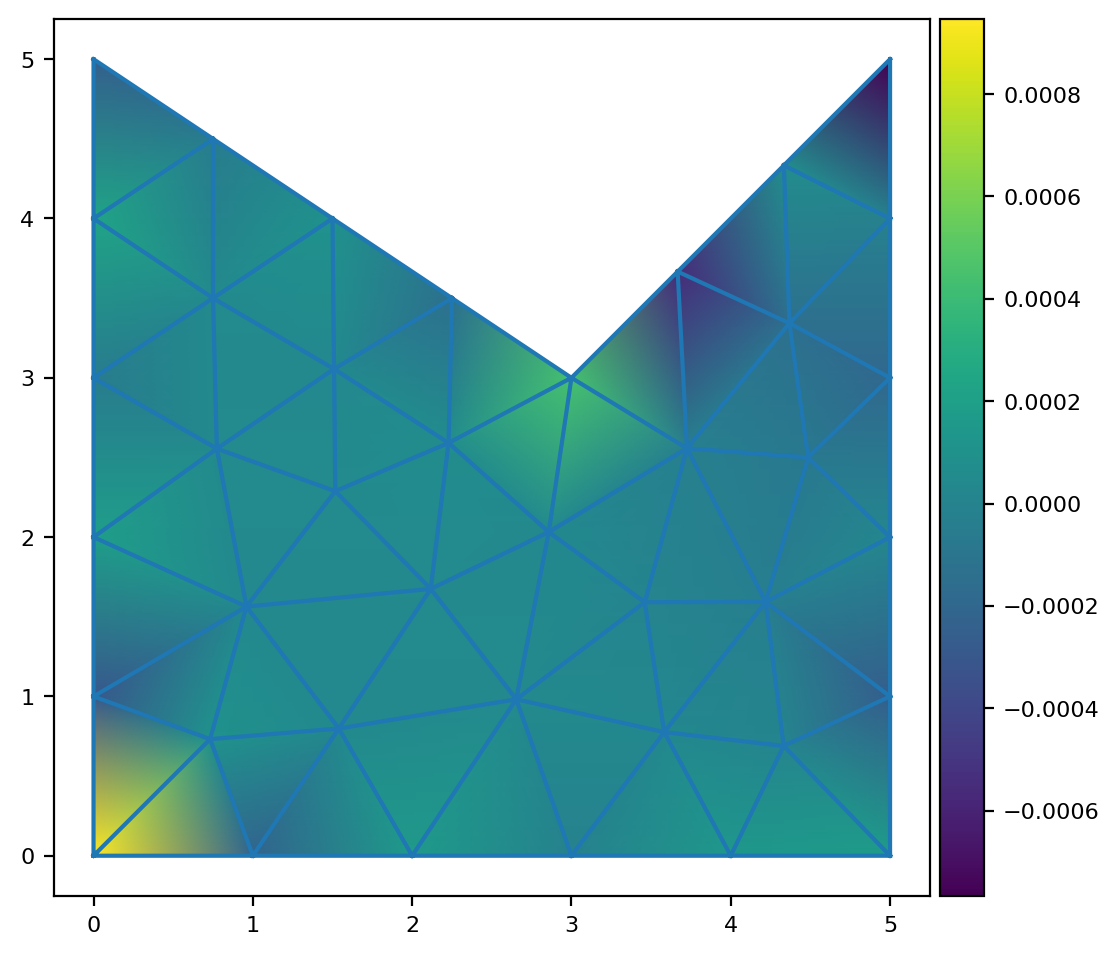

In [4]:
def u(p, n):
  return 2 * p[..., 0] + 3 * p[..., 1] - 4


def flow(p, n):
  return 2 * n[..., 0] + 3 * n[..., 1]


domain = next(BemDomain(domain) for domain in Mesh.load("test.geo"))
dir_vector = u(domain.vertices[: domain.ext_dof_count], 0)

domain.assembly({"dirichlet": flow})
domain.decompose()
sol = domain.solve_neumann(domain.load_vector)

sol -= domain.kernel[0] * (sol @ domain.kernel[0]) / (domain.kernel[0] @ domain.kernel[0])
u_ort = dir_vector - domain.kernel[0] * (dir_vector @ domain.kernel[0]) / (domain.kernel[0] @ domain.kernel[0])

print(f"Neumann problem error: {np.linalg.norm(sol - u_ort)/np.linalg.norm(u_ort)}")
print(
  f"Dirichlet problem error: {np.linalg.norm(domain.solve_dirichlet(dir_vector) - domain.load_vector)/np.linalg.norm(domain.load_vector)}"
)

sol = domain.calc_solution(sol)
sol -= np.ones_like(sol) * (sol @ np.ones_like(sol)) / (np.ones_like(sol) @ np.ones_like(sol))
u_ort = u(domain.vertices, 0) - np.ones_like(sol) * (u(domain.vertices, 0) @ np.ones_like(sol)) / (np.ones_like(sol) @ np.ones_like(sol))

print(f"Error in points: {np.linalg.norm(sol - u_ort) / np.linalg.norm(u_ort)}")

fig, ax = plt.subplots()
ax.set_aspect("equal")
tpc = ax.tripcolor(domain.vertices[:, 0], domain.vertices[:, 1], sol - u_ort, triangles=domain.elements[0].node_tags, shading="gouraud")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(tpc, cax=cax)
ax.triplot(domain.vertices[:, 0], domain.vertices[:, 1], domain.elements[0].node_tags)
plt.show()

# FETI Simple Tests

In [5]:
def print_feti_information(problem):
  print(f"Feti problem: domains {len(problem.domains)}, dual size {problem.dual_size}, primal size {problem.primal_size}")
  print(f"Condition number estimation {problem.condition_number_estimate():.2f}")


def print_domains_information(domains):
  fem = [domain for domain in domains if isinstance(domain, FemDomain)]
  print(f"FEM domains {len(fem)}, elements {sum(d.element_count for d in fem)}, dof {sum(d.dof_count for d in fem)}")
  bem = [domain for domain in domains if isinstance(domain, BemDomain)]
  print(f"BEM domains {len(bem)}, elements {sum(d.element_count for d in bem)}, dof {sum(d.dof_count for d in bem)}")

In [10]:
def simple_test(mesh, dirichlet_name, materials, bem=False):
  mesh.renumber()
  domains = [(BemDomain if bem else FemDomain)(data) for data in mesh]
  print_domains_information(domains)

  problem = FetiProblem(domains)
  problem.assembly(dirichlet_name, materials)
  print_feti_information(problem)
  print()

  u = materials.get(dirichlet_name, lambda p, n: 0)
  problem.add_skeleton_projection(u, {name: {dirichlet_name} for name in materials.keys()})

  problem.decompose()
  for precond, Q in [
    ("Dirichlet", "Diag"),
    ("Lumped Dirichlet", "Diag"),
    ("Dirichlet", "I"),
    ("Lumped Dirichlet", "I"),
    ("Dirichlet", "M"),
    ("Lumped Dirichlet", "M"),
    ("I", "I"),
  ]:
    print(f"Precondition = {precond}, Q = {Q}")
    solutions = problem.solve(precond, Q, 1e-10)

    I = sparse.eye_array(problem.dual_size).todense()
    A = problem.project_transposed(problem.operator(I))
    M = problem.project(problem.preconditioner(I, precond))

    def cond(A):
      svd = np.linalg.svd(A)[1]
      return svd.max() / svd.min(where=svd > 1e-10, initial=np.inf)

    cond_est = problem.condition_number_estimate()
    print(f"k(A) = {cond(A):.2f}, k(MA) = {(c := cond(M @ A)):.2f}, k(MA)/est = {c/cond_est:.2f}")
    err_norm = 0
    u_norm = 0
    for domain, sol in zip(problem.domains, solutions):
      err_norm = np.linalg.norm(u(domain.vertices, 0) - sol)
      u_norm = np.linalg.norm(u(domain.vertices, 0))

    print(f"Relative error: {err_norm/u_norm:.2e}")

## FEM Linear test

In [11]:
def u(p, n):
  return 2 * p[..., 0] + 3 * p[..., 1] - 4


def flow(p, n):
  return 2 * n[..., 0] + 3 * n[..., 1]


def source(p, n):
  return 0

In [12]:
materials = {"dirichlet": u, "steel": {"neumann": flow, "steel": source}}

In [13]:
simple_test(Mesh.load("test.geo", refine_k=3, num_part=10), "dirichlet", materials)

FEM domains 10, elements 3584, dof 2087
BEM domains 0, elements 0, dof 0
Feti problem: domains 10, dual size 390, primal size 10
Condition number estimation 8.96

Precondition = Dirichlet, Q = Diag
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
CG iters 20
<class 'numpy.ndarray'>
k(A) = 185.35, k(MA) = 51.77, k(MA)/est = 5.78
Relative error: 6.79e-12
Precondition = Lumped Dirichlet, Q = Diag
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<cla

## BEM Linear test

In [10]:
def u(p, n):
  return 2 * p[..., 0] + 3 * p[..., 1] - 4


def flow(p, n):
  return 2 * n[..., 0] + 3 * n[..., 1]


materials = {"dirichlet": u, "steel": {"neumann": flow, "steel": 0}}
simple_test(Mesh.load("test.geo", 3, 10), "dirichlet", materials, bem=True)

FEM domains 0, elements 0, dof 0
BEM domains 10, elements 570, dof 570
Feti problem: domains 10, dual size 390, primal size 10
Condition number estimation 17.55

Precondition = Dirichlet, Q = Diag
CG iters 19
k(A) = 73.50, k(MA) = 12.06, k(MA)/est = 0.69
Relative error: 5.81e-06
Precondition = Lumped Dirichlet, Q = Diag
CG iters 27
k(A) = 73.50, k(MA) = 12.06, k(MA)/est = 0.69
Relative error: 5.81e-06
Precondition = Dirichlet, Q = I
CG iters 19
k(A) = 73.50, k(MA) = 12.04, k(MA)/est = 0.69
Relative error: 5.81e-06
Precondition = Lumped Dirichlet, Q = I
CG iters 27
k(A) = 73.50, k(MA) = 12.04, k(MA)/est = 0.69
Relative error: 5.81e-06
Precondition = Dirichlet, Q = M
CG iters 17
k(A) = 94.44, k(MA) = 9.42, k(MA)/est = 0.54
Relative error: 5.81e-06
Precondition = Lumped Dirichlet, Q = M
CG iters 25
k(A) = 86.63, k(MA) = 9.37, k(MA)/est = 0.53
Relative error: 5.81e-06
Precondition = I, Q = I
CG iters 63
k(A) = 73.50, k(MA) = 12.04, k(MA)/est = 0.69
Relative error: 5.81e-06


## FEM Quadratic test

In [11]:
def u(p, n):
  return p[..., 0] ** 2


def flow(p, n):
  return 2 * p[..., 0] * n[..., 0]


materials = {"dirichlet": u, "steel": {"neumann": flow, "steel": -2}}
simple_test(Mesh.load("test.geo", 3, 10), "dirichlet", materials)

FEM domains 10, elements 3584, dof 2087
BEM domains 0, elements 0, dof 0
Feti problem: domains 10, dual size 390, primal size 10
Condition number estimation 8.96

Precondition = Dirichlet, Q = Diag
CG iters 20
k(A) = 185.35, k(MA) = 51.77, k(MA)/est = 5.78
Relative error: 8.21e-04
Precondition = Lumped Dirichlet, Q = Diag
CG iters 40
k(A) = 185.35, k(MA) = 51.77, k(MA)/est = 5.78
Relative error: 8.21e-04
Precondition = Dirichlet, Q = I
CG iters 20
k(A) = 185.35, k(MA) = 51.78, k(MA)/est = 5.78
Relative error: 8.21e-04
Precondition = Lumped Dirichlet, Q = I
CG iters 40
k(A) = 185.35, k(MA) = 51.78, k(MA)/est = 5.78
Relative error: 8.21e-04
Precondition = Dirichlet, Q = M
CG iters 18
k(A) = 251.13, k(MA) = 182.89, k(MA)/est = 20.41
Relative error: 8.21e-04
Precondition = Lumped Dirichlet, Q = M
CG iters 38
k(A) = 186.09, k(MA) = 52.13, k(MA)/est = 5.82
Relative error: 8.21e-04
Precondition = I, Q = I
CG iters 69
k(A) = 185.35, k(MA) = 51.78, k(MA)/est = 5.78
Relative error: 8.21e-04


## BEM Quadratic test

In [12]:
def u(p, n):
  return p[..., 0] ** 2


def flow(p, n):
  return 2 * p[..., 0] * n[..., 0]


materials = {"dirichlet": u, "steel": {"neumann": flow, "steel": -2}}
simple_test(Mesh.load("test.geo", 3, 10), "dirichlet", materials, bem=True)

FEM domains 0, elements 0, dof 0
BEM domains 10, elements 570, dof 570
Feti problem: domains 10, dual size 390, primal size 10
Condition number estimation 17.55

Precondition = Dirichlet, Q = Diag
CG iters 19
k(A) = 73.50, k(MA) = 12.06, k(MA)/est = 0.69
Relative error: 9.38e-04
Precondition = Lumped Dirichlet, Q = Diag
CG iters 28
k(A) = 73.50, k(MA) = 12.06, k(MA)/est = 0.69
Relative error: 9.38e-04
Precondition = Dirichlet, Q = I
CG iters 19
k(A) = 73.50, k(MA) = 12.04, k(MA)/est = 0.69
Relative error: 9.38e-04
Precondition = Lumped Dirichlet, Q = I
CG iters 28
k(A) = 73.50, k(MA) = 12.04, k(MA)/est = 0.69
Relative error: 9.38e-04
Precondition = Dirichlet, Q = M
CG iters 17
k(A) = 94.44, k(MA) = 9.42, k(MA)/est = 0.54
Relative error: 9.38e-04
Precondition = Lumped Dirichlet, Q = M
CG iters 25
k(A) = 86.63, k(MA) = 9.37, k(MA)/est = 0.53
Relative error: 9.38e-04
Precondition = I, Q = I
CG iters 64
k(A) = 73.50, k(MA) = 12.04, k(MA)/est = 0.69
Relative error: 9.38e-04
